# Demo para analizar y estudiar los datos disponibles de TIPOS de Flores IRIS


In [1]:
#@title Librerías a usar
import keras
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
  
import ipywidgets as widgets
from ipywidgets import Box

print("Librerías cargadas")

Librerías cargadas


In [2]:
#@title Funciones Auxiliares

# variables auxiliares 
atributo_clase = ""

# devuelve listas de columnas numéricas y no numéricas
def devolNombreColumnas(ndf):
  colValues = []
  colNoValues = []
  for col in ndf.columns:
    if ndf[col].dtypes == "object":
      colNoValues.append( col )
    else:
      colValues.append( col )
  return colValues, colNoValues

# función auxiliar para separar datos de entrada y de salida
def separarDatosXY(ndf, atributo_clase="", xSoloNros=True):
  # hace una copia auxiliar del data frame
  cdf = ndf.copy()
  # saca el atributo clase (OPCIONAL)
  if atributo_clase == "":
    Y = []
  else:
    # datos atributo clase
    Y = np.array( cdf.pop(atributo_clase).fillna("-NAN-") )
  if xSoloNros:
    # se queda sólo con los atributos numéricos (OPCIONAL)
    for col in cdf.columns:
      if cdf[col].dtypes == "object":
          cdf.pop( col )
  # datos de entrada
  X = np.array(cdf.fillna(0.001))
  return X, Y, np.array(cdf.columns)

def convColsNumericas(ndf, atributos_no_convertir = []):
  # hace una copia auxiliar del data frame
  cdf = ndf.copy()
  # convierte todas las no numéricas a numéricas (OPCIONAL)
  for col in cdf.columns:
    if col not in atributos_no_convertir:
      if cdf[col].dtypes == "object":
        # genera diccionario de valores
        valores = cdf[col].unique()
        diccValores = dict(zip(valores, range(len(valores))))
        # realiza el reemplazo
        cdf[col] = cdf[col].map(lambda s: diccValores.get(s) if s in diccValores else s)
  return cdf
  
print("Funciones auxiliares definidas.")

Funciones auxiliares definidas.


In [3]:
#@title Montar Google Drive
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

#@markdown ### Directorio  en Google Drive:
path = '/content/gdrive/My Drive/IA/demo IRIS'  #@param {type:"string"}

#@markdown ### Archivo de datos a utilizar:
archivo_datos = '/datos/IRIS.csv'  #@param {type:"string"}

print("Usando datos de ", path+archivo_datos)

Mounted at /content/gdrive
Usando datos de  /content/gdrive/My Drive/IA/demo IRIS/datos/IRIS.csv


In [4]:
#@title Cargar datos { run: "auto" }

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos)
ndf = df
print("\n> 10 primeros ejemplos de los datos: ")
display(df.head())



> 10 primeros ejemplos de los datos: 


,LargoSepalo,AnchoSepalo,LargoPetalo,AnchoPetalo,Clase
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


# Estadísticas:

In [5]:
#@title Mostrar Estadísticas de Datos Cargados { run: "auto" }

# función auxiliar
def generar_estadisticas_detalladas(orDF, titulo=""):
  # título
  print("\n", titulo, ": ") 
  # obtiene las estadísticas generales
  estDF = orDF.describe().transpose()
  #  genera y formatea las estadísticas
  if "min" in estDF and "max" in estDF:
    rangoValores = "[ " + estDF["min"].apply('{:.2f}'.format) + " ; " + estDF["max"].apply('{:.2f}'.format) + " ]"    
  else:
    rangoValores = estDF["unique"].apply('{:.0f}'.format)
  rangoValores.name = "Rango Valores"
  # para campos no numéricos muestra las cantidades por valor
  for col in orDF.columns:
    if orDF[col].dtypes == "object":
      auxStr = str( orDF[col].value_counts() ).replace("\n", " ; ")
      if (auxStr.index("Name")-3) > 0:
        # saca lo del final porque no sirve
        auxStr = auxStr[:auxStr.index("Name")-3]
      rangoValores[col] = "{ " + auxStr + " }"
  if "mean" in estDF and "std" in estDF:      
    promValores = estDF["mean"].apply('{:.3f}'.format) + " ± " + estDF["std"].apply('{:.3f}'.format)
  else:
    promValores = estDF["count"].apply('{:.0f}'.format)
  promValores.name = "Promedio ± Desvío"
  # obtiene valores "ceros" y nulos
  zero_val = (orDF == 0.00).astype(int).sum(axis=0)
  zero_val.name = "¿Valores Ceros?"
  mis_val = orDF.isnull().sum()
  mis_val.name = "¿Valores Nulos?"
  # prepara la nueva tabla para mostrar
  nTable = pd.concat([orDF.dtypes, rangoValores, promValores, zero_val, mis_val], axis=1)
  nTable = nTable.rename( columns = {0: 'Tipo Valor',  1: 'Rango Valores', 2: 'Promedio ± Desvío', 3: '¿Valores Ceros?', 4: '¿Valores Nulos?' } )
  # muestra la nueva tabla
  pd.set_option('max_colwidth', None)
  display(nTable.fillna("-"))
  print("Tiene " + str(orDF.shape[1]) + " atributos y " + str(orDF.shape[0]) + " ejemplos.")
  print("\n")
  return 

# muestra las estadísticas
generar_estadisticas_detalladas(df, "> Estadísticas de los datos cargados") 



 > Estadísticas de los datos cargados : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
LargoSepalo,float64,[ 4.30 ; 7.90 ],5.843 ± 0.828,0,0
AnchoSepalo,float64,[ 2.00 ; 4.40 ],3.054 ± 0.434,0,0
LargoPetalo,float64,[ 1.00 ; 6.90 ],3.759 ± 1.764,0,0
AnchoPetalo,float64,[ 0.10 ; 2.50 ],1.199 ± 0.763,0,0
Clase,int64,[ 1.00 ; 3.00 ],2.000 ± 0.819,0,0


Tiene 5 atributos y 150 ejemplos.




In [6]:
#@title Definir Valores Discretos para Atributo Clase (OPCIONAL) { run: "auto" }

#@markdown ### Nombre del atributo clase / objetivo:
atributo_clase = 'Clase' #@param {type:"string"}
#@markdown ### Descripción de los valores del atributo clase / objetivo:  
aplicar_valores_clases_discretos = True #@param {type:"boolean"}
nombre_valores_clases = 'na, Setosa, Versicolor, Virginica' #@param {type:"string"}
#@markdown ### (Nota: siempre debe comienzar en 0, por lo que si no tiene valor 0, se debe agregar "na" al inicio de la lista)

# por si no se aplica
ndf = df

if atributo_clase != "":

  # controla que exista el atributo_clase
  if atributo_clase not in df:
    raise ValueError("El atributo '" + atributo_clase + "' no existe en los datos cargados!!!")

  # asignar valores discretos para Atributo Clase
  if aplicar_valores_clases_discretos and len(nombre_valores_clases) > 0:
    CLASES = nombre_valores_clases.split(',')
    if len(CLASES) > 0:
      print("> Acualizando valores del atributo clase: ", atributo_clase, ":")
      ndf = df.copy()
      i = 0
      for val in CLASES:
        ndf[atributo_clase] = ndf[atributo_clase].replace(i, val)
        i = i + 1
  else:
    print("No se aplica la actualización de los valores del atributo clase: ", atributo_clase, ".")

  # mostrar nuevas estadísticas por Clase
  for val in  ndf[atributo_clase].unique():
    auxDF = ndf[ ndf[atributo_clase] == val]
    auxDF = auxDF.drop(labels=atributo_clase, axis=1) 
    generar_estadisticas_detalladas(auxDF, "- Estadísticas por valor de clase '" + str(val) + "'" )

else:
  print("No se ha definido el nombre del atributo clase.")

> Acualizando valores del atributo clase:  Clase :

 - Estadísticas por valor de clase ' Setosa' : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
LargoSepalo,float64,[ 4.30 ; 5.80 ],5.006 ± 0.352,0,0
AnchoSepalo,float64,[ 2.30 ; 4.40 ],3.418 ± 0.381,0,0
LargoPetalo,float64,[ 1.00 ; 1.90 ],1.464 ± 0.174,0,0
AnchoPetalo,float64,[ 0.10 ; 0.60 ],0.244 ± 0.107,0,0


Tiene 4 atributos y 50 ejemplos.



 - Estadísticas por valor de clase ' Versicolor' : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
LargoSepalo,float64,[ 4.90 ; 7.00 ],5.936 ± 0.516,0,0
AnchoSepalo,float64,[ 2.00 ; 3.40 ],2.770 ± 0.314,0,0
LargoPetalo,float64,[ 3.00 ; 5.10 ],4.260 ± 0.470,0,0
AnchoPetalo,float64,[ 1.00 ; 1.80 ],1.326 ± 0.198,0,0


Tiene 4 atributos y 50 ejemplos.



 - Estadísticas por valor de clase ' Virginica' : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
LargoSepalo,float64,[ 4.90 ; 7.90 ],6.588 ± 0.636,0,0
AnchoSepalo,float64,[ 2.20 ; 3.80 ],2.974 ± 0.322,0,0
LargoPetalo,float64,[ 4.50 ; 6.90 ],5.552 ± 0.552,0,0
AnchoPetalo,float64,[ 1.40 ; 2.50 ],2.026 ± 0.275,0,0


Tiene 4 atributos y 50 ejemplos.




In [7]:
#@title Convertir atributos no numéricos a numéricos (OPCIONAL) { run: "auto" }

convertir_valores_noNumericos_a_Numericos = False #@param {type:"boolean"}
#@markdown ### (Nota: si hay un atributo_clase definido, el mismo no es convertido)

# convierte a valores numéricos
if convertir_valores_noNumericos_a_Numericos:
  ndf = convColsNumericas(ndf, [atributo_clase])

  # mostrar estadísticas generales
  generar_estadisticas_detalladas(ndf, "> Nuevas Estadísticas Generales valores convertidos") 
else:
  print("No se aplica la conversión a valores numéricos.")

No se aplica la conversión a valores numéricos.


In [8]:
#@title Normalizar datos numéricos (OPCIONAL) { run: "auto" }

#@markdown ### Si se aplica, seleccione el tipo de método de normalización a aplicar:
aplica_normalizacion = False #@param {type:"boolean"}
tipo_normalizacion = "Robust Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

if aplica_normalizacion:

  print("10 primeros ejemplos antes de normalizar: ")
  display( ndf.head() )

  from sklearn import preprocessing

  # elegir el método de normalización
  if tipo_normalizacion == "Standard Scaler": 
    scaler = preprocessing.StandardScaler()
  elif tipo_normalizacion == "MinMax Scaler": 
    scaler = preprocessing.MinMaxScaler()
  elif tipo_normalizacion == "MaxMax Scaler": 
    scaler = preprocessing.MaxAbsScaler()
  elif tipo_normalizacion == "Robust Scaler": 
    scaler = preprocessing.RobustScaler()
  
  # aplica la normalización sólo en columnas de datos
  for col in ndf.columns:
    if ndf[col].dtypes != "object": 
      ndf[col] = scaler.fit_transform(ndf[col].values.reshape(-1, 1))

  print("\n\n10 primeros ejemplos después de normalizar: ")
  display( ndf.head() )

  # muestra las estadísticas del normalizado
  generar_estadisticas_detalladas(ndf, "> Estadísticas de los datos normalizados") 
else:
  print("No se aplica la normalización de los datos.")

No se aplica la normalización de los datos.


# Gráficos Estadísticos:

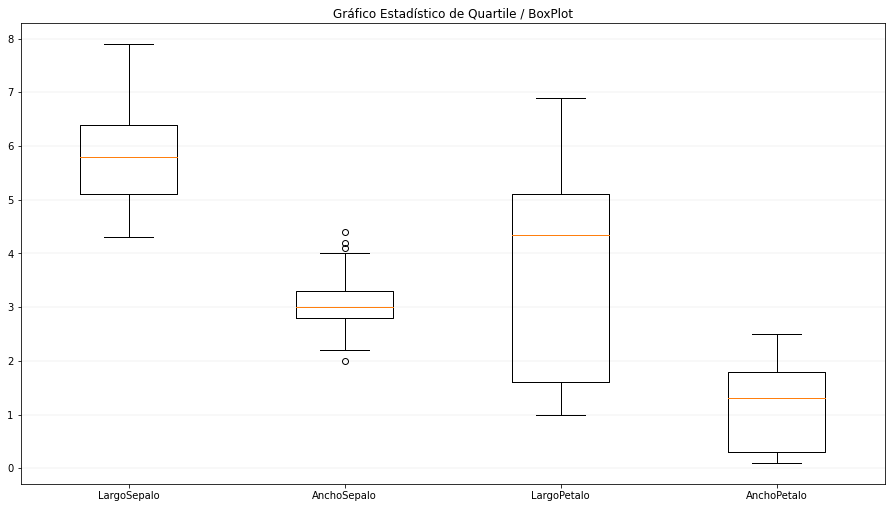

In [9]:
#@title Generar gráfico de  Quartile o BoxPlot { run: "auto" }

generar_grafico_por_valor_clase = False #@param {type:"boolean"}

def genGraph_BoxPlot(ndf, titulo):
  fig = plt.figure(figsize=(15,8)) 
  legValues = []
  colValues = []
  for col in ndf.columns:    
    if ndf[col].dtypes != "object":
      legValues.append( col )
      colValues.append( ndf[col].fillna(0.001) )
  if len(colValues)>0:
    ax = fig.add_axes( [0, 0, 0.8, 0.8] )
    ax.boxplot( colValues )
    ax.set_xticklabels( legValues )
  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.title(titulo)
  plt.show()

# genera los gráficos
tit = "Gráfico Estadístico de Quartile / BoxPlot"
if generar_grafico_por_valor_clase:
  for val in  ndf[atributo_clase].unique():
    auxDF = ndf[ ndf[atributo_clase] == val]
    auxDF = auxDF.drop(labels=atributo_clase, axis=1) 
    genGraph_BoxPlot(auxDF, tit + " para valor de clase '" + str(val) + "'" )

else:
  genGraph_BoxPlot(ndf, tit)


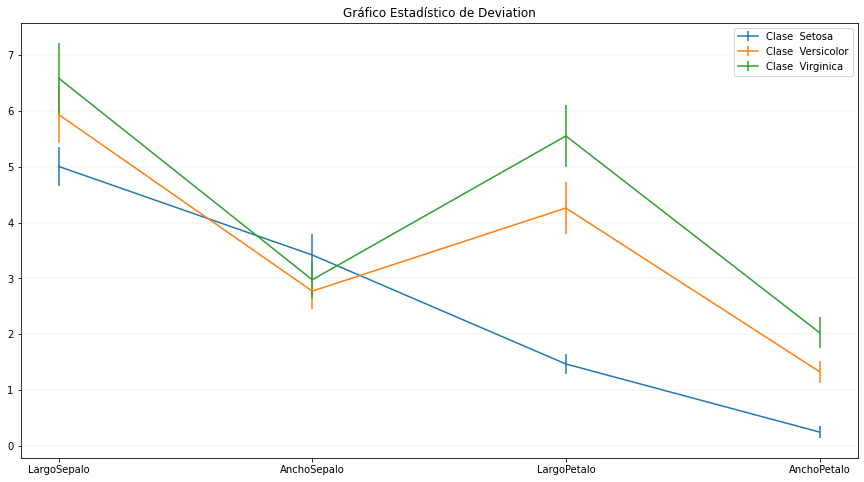

In [10]:
#@title Generar gráfico de Deviation  { run: "auto" }

generar_grafico_por_valor_clase = True #@param {type:"boolean"}

def genGraph_Deviation(oriDF, titulo, porClase):
  fig = plt.figure(figsize=(15,8))   
  
  listDF = []
  legValues = []
  if porClase:
    # genera sub-DF por valor de clase
    for val in oriDF[atributo_clase].unique():
      auxDF = oriDF[ oriDF[atributo_clase] == val]
      auxDF = auxDF.drop(labels=atributo_clase, axis=1) 
      listDF.append( auxDF.fillna(0.001) )
      legValues.append( atributo_clase + " " + str(val))       
  else:
    # usa todos los datos como sub-DF
    listDF.append( oriDF )
  
  # genera línea por sub-DF
  for ndf in listDF:
    xLabel = []
    meanValues = []
    stdValues = []
    for col in ndf.columns:
      if ndf[col].dtypes != "object":      
        xLabel.append( col )
        meanValues.append( ndf[col].mean() )
        stdValues.append( ndf[col].std() )
    plt.errorbar(xLabel, meanValues, yerr=stdValues)

  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.title(titulo)
  if len(legValues) > 0:
    plt.legend(legValues, loc='best')
  plt.show()


# genera los gráficos
tit = "Gráfico Estadístico de Deviation"
genGraph_Deviation(ndf, tit, generar_grafico_por_valor_clase)


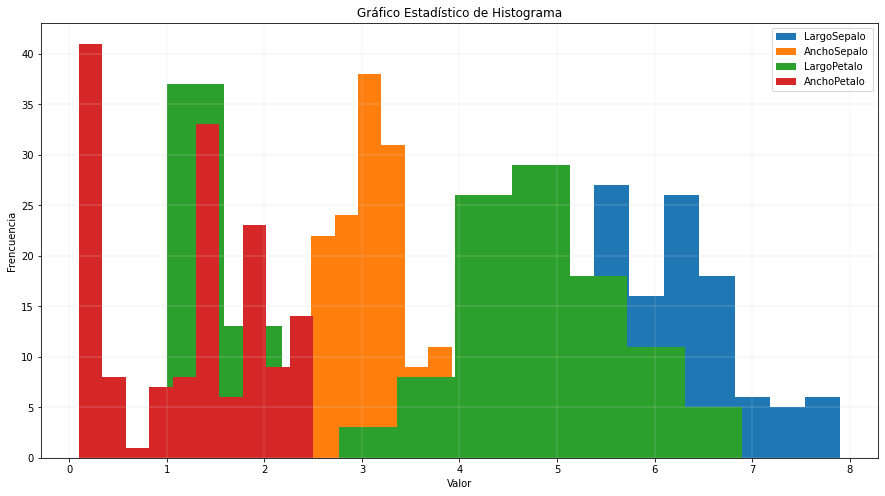

In [11]:
#@title Generar gráfico de Histogram { run: "auto" }

generar_grafico_por_valor_clase = False #@param {type:"boolean"}
cantidad_bins = 10 #@param {type:"integer"}

if cantidad_bins <= 1:
  cantidad_bins = 1

def genGraph_Series(ndf, titulo):
  fig = plt.figure(figsize=(15,8)) 
  legValues = []
  for col in ndf.columns:
    if ndf[col].dtypes != "object":
      plt.hist( ndf[col].fillna(0.001), bins = cantidad_bins )
      legValues.append( col )
  plt.grid(color='lightgrey', which='major', axis='x', linestyle='solid', linewidth=0.2)
  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.title(titulo)
  plt.xlabel('Valor')
  plt.ylabel('Frencuencia')
  plt.legend(legValues, loc='best')
  plt.show()


# genera los gráficos
tit = "Gráfico Estadístico de Histograma"
if generar_grafico_por_valor_clase:
  for val in  ndf[atributo_clase].fillna("-NAN-").unique():
    auxDF = ndf[ ndf[atributo_clase] == val]
    auxDF = auxDF.drop(labels=atributo_clase, axis=1) 
    genGraph_Series(auxDF, tit + " para valor de clase '" + str(val) + "'" )

else:
  genGraph_Series(ndf, tit)


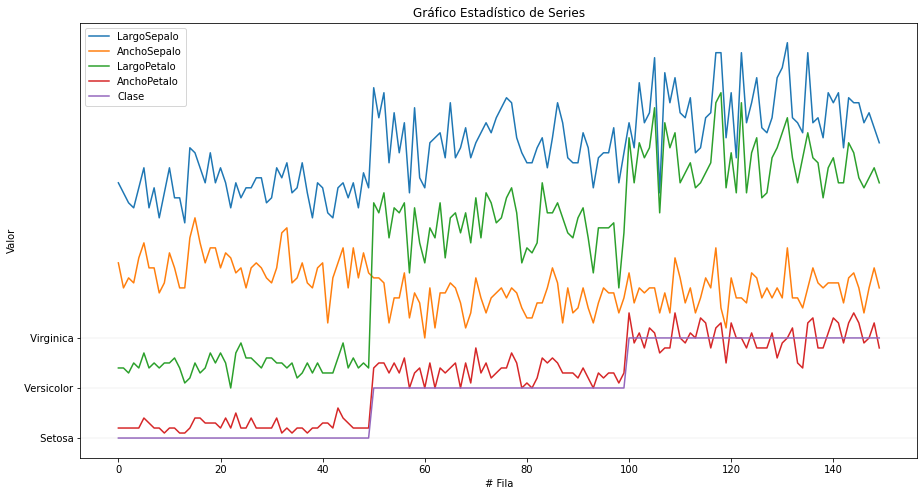

In [12]:
#@title Generar gráfico de Series { run: "auto" }

generar_grafico_por_valor_clase = False #@param {type:"boolean"}
incluir_valores_discretos = True #@param {type:"boolean"}

def genGraph_Series(ndf, titulo):
  fig = plt.figure(figsize=(15,8)) 
  legValues = []
  for col in ndf.columns:
    if incluir_valores_discretos or ndf[col].dtypes != "object":
      if ndf[col].dtypes == "object":
        plt.plot( ndf[col].fillna("-NAN-") )
      else:
        plt.plot( ndf[col].fillna(0.001) )
      legValues.append( col )
  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.title(titulo)
  plt.ylabel('Valor')
  plt.xlabel('# Fila')
  plt.legend(legValues, loc='best')
  plt.show()


# genera los gráficos
tit = "Gráfico Estadístico de Series"
if generar_grafico_por_valor_clase:
  for val in  ndf[atributo_clase].unique():
    auxDF = ndf[ ndf[atributo_clase] == val]
    auxDF = auxDF.drop(labels=atributo_clase, axis=1) 
    genGraph_Series(auxDF, tit + " para valor de clase '" + str(val) + "'" )

else:
  genGraph_Series(ndf, tit)


In [13]:
#@title Generar gráfico de Scatter 

# carga las columnas numéricas y no numéricas
colValues, colNoValues = devolNombreColumnas(ndf)
colNoValues.insert(0, "-")

# agrega los combos
comboColX = widgets.Dropdown(
    options=colValues,
    value=colValues[0],
    description='Columna X:',
    disabled=False,
)
if len(colValues)>1:
  valYsel = colValues[1]
else:
  valYsel = colValues[0]

comboColY = widgets.Dropdown(
    options=colValues,
    value=valYsel,
    description='Columna Y:',
    disabled=False,
)

comboColZ = widgets.Dropdown(
    options=colNoValues,
    value=colNoValues[0],
    description='Columna Z:',
    disabled=False,
)

ui = widgets.HBox([comboColX, comboColY, comboColZ])

def genGraph_Scatter(ndf, colx, coly, colz, titulo):
  if colx not in ndf or coly not in ndf or (colz!="" and colz not in ndf):
    if colx not in ndf:
      print("Nombre de columna X '" + colx + "' no existente!!")
    elif coly not in ndf:
      print("Nombre de columna Y '" + colx + "' no existente!!")
    elif (colz!="" and colz not in ndf):
      print("Nombre de columna Z '" + colx + "' no existente!!")
    return
  else:
    fig = plt.figure(figsize=(15,8)) 
    if colz == "":
      # gráfico general
      plt.scatter(ndf[colx], ndf[coly])
    else:
      # gráfico marcando colores por valor de colz
      legValues = []
      for val in  ndf[colz].unique():
        auxDF = ndf[ ndf[colz] == val]
        auxDF = auxDF.drop(labels=colz, axis=1) 
        plt.scatter(auxDF[colx], auxDF[coly])
        legValues.append(val)
      plt.legend(legValues, loc='best')
    plt.xlabel(colx)
    plt.ylabel(coly)
    plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
    plt.grid(color='lightgrey', which='major', axis='x', linestyle='solid', linewidth=0.3)
    plt.show()

def cambiaSeleccion(x, y, z):
  # llama a la función 
  # para generar el gráfico con las columnas seleccionadas
  tit = "Gráfico Estadístico de Scatter"
  if z == "-":
    z = ""
  genGraph_Scatter(ndf, x, y, z, tit)

out = widgets.interactive_output(cambiaSeleccion, {'x': comboColX, 'y': comboColY, 'z': comboColZ})
display(ui, out)

Output()

Matriz de Correlación:



,LargoSepalo,AnchoSepalo,LargoPetalo,AnchoPetalo
LargoSepalo,1.000,-0.109,0.872,0.818
AnchoSepalo,-0.109,1.000,-0.421,-0.357
LargoPetalo,0.872,-0.421,1.000,0.963
AnchoPetalo,0.818,-0.357,0.963,1.000


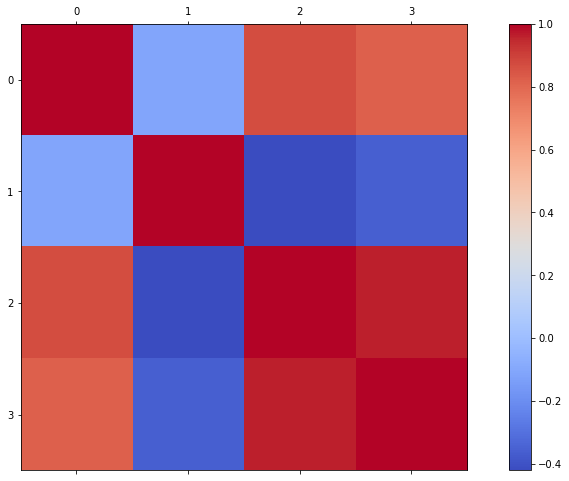

In [14]:
#@title Generar Matriz de Correlación 
# muestra la matriz
print('Matriz de Correlación:\n')
corr = ndf.corr() 
display( corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(3) )
print("\n")

# muestra la figura
fig = plt.figure(figsize=(15,8)) 
plt.matshow(corr,  fignum=fig.number, cmap='coolwarm')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
#plt.title('Matriz de Correlación')
plt.show()

#Resultados de aplicar Algoritmos de Minería de Datos:

In [15]:
#@title Aplicar Descubrimiento de Reglas ( Decision Tree ) { run: "auto" }

# carga las columnas no numéricas
_, colNoValues = devolNombreColumnas(ndf)

if len(colNoValues)<1:
  raise ValueError("No se encuentra ningún atributo no numérico para utilizar como objetivo!!!")

# agrega los combos
comboClase = widgets.Dropdown(
    options=colNoValues,
    value=(atributo_clase if atributo_clase!="" else colNoValues[0]),
    description='Atr.Clase:',
    disabled=False,
)

ui = widgets.HBox([comboClase])

def cambiaSeleccion(atributo_clase_tree):      

    # obtiene los datos para entrenar el algoritmo
    X, Y, xColName = separarDatosXY(ndf, atributo_clase_tree, xSoloNros=True)

    # determina nombre de atributos y valores clase
    cols = xColName
    classvalues = np.unique(Y)

    # genera el árbol y lo muestra
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X, Y)

    # muestra el árbol
    plt.figure(figsize=(15,8))   
    tree.plot_tree(clf, 
                  feature_names=cols, 
                  class_names=classvalues, 
                  impurity=False, 
                  rounded=True, 
                  fontsize=11)
    plt.show()

out = widgets.interactive_output(cambiaSeleccion, {'atributo_clase_tree': comboClase})
display(ui, out)    

Output()

In [16]:
#@title Aplicar Ponderación ( Naive Bayes )

# carga las columnas numéricas y no numéricas
colValues, colNoValues = devolNombreColumnas(ndf)

if len(colNoValues)<1:
  raise ValueError("No se encuentra ningún atributo no numérico para utilizar como objetivo!!!")

# agrega los combos
comboEnt = widgets.Dropdown(
    options=colValues,
    value=colValues[0],
    description='Atr.Entrada:',
    disabled=False,
)

comboClase = widgets.Dropdown(
    options=colNoValues,
    value=colNoValues[0],
    description='Atr.Clase:',
    disabled=False,
)

ui = widgets.HBox([comboEnt, comboClase])

def cambiaSeleccion(atributo_valor_naiveBayes, atributo_clase_naiveBayes):
  # genera el gráfico
  plt.figure(figsize=(15,8))
  legValues = []   
  # procesa los valores del atributo clase
  for val in ndf[atributo_clase_naiveBayes].fillna("-NAN-").unique():
      # filtra los datos
      auxDF = ndf[ ndf[atributo_clase_naiveBayes] == val]
      # obtiene valores X, Y de clase y atributo
      Y = np.array(auxDF.pop(atributo_clase_naiveBayes).fillna("-NAN-"))
      X = np.array(auxDF[atributo_valor_naiveBayes].fillna(0.001))   
      if len(X)>0 and len(Y)>0:
        legValues.append(val)
        # calcula la densidad
        # instantiate and fit the KDE model
        kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
        kde.fit(X[:, None])      
        # score_samples returns the log of the probability density
        x_d = np.linspace(np.min(X), np.max(X), 1000)
        logprob = kde.score_samples(x_d[:, None])
        # genera área del atributo
        plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
        plt.plot(X, np.full_like(X, -0.01), '|k', markeredgewidth=1)
  plt.xlabel("Valores")
  plt.ylabel("Frecuencia")
  plt.legend(legValues, loc='best')
  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.show()

out = widgets.interactive_output(cambiaSeleccion, {'atributo_valor_naiveBayes': comboEnt, 'atributo_clase_naiveBayes': comboClase })
display(ui, out)


Output()

In [17]:
#@title Aplicar Clustering ( K-Means ) { run: "auto" }

#@markdown ### Cantidad de clústeres a generar:
cantidad_clusters = 3 #@param {type:"integer"}
#@markdown ### Nombre del atributo clase / objetivo a descartar en el clustering:
atributo_clase_descartar_clustering = "" #@param {type:"string"}

# como mínimo se tienen que generar dos clusters
if cantidad_clusters < 2:
  cantidad_clusters = 2

# controla que exista el atributo_clase
if atributo_clase_descartar_clustering != "" and atributo_clase_descartar_clustering not in ndf:
  raise ValueError("El atributo '" + atributo_clase_descartar_clustering + "' no existe en los datos cargados!!!")

# obtiene los datos para entrenar el algoritmo
X, Y, colValues = separarDatosXY(ndf, atributo_clase_descartar_clustering, xSoloNros=True)
colValues = list(colValues)

# Entrena K-Means
kmeans = KMeans(n_clusters=cantidad_clusters).fit(X)
centroids = kmeans.cluster_centers_
print("Centroides Generados: \n", centroids)
print("\n")

# Determina la salida
labels = kmeans.predict(X)

# agrega los combos
comboColX = widgets.Dropdown(
    options=colValues,
    value=colValues[0],
    description='Columna X:',
    disabled=False,
)
if len(colValues)>1:
  valYsel = colValues[1]
else:
  valYsel = colValues[0]

comboColY = widgets.Dropdown(
    options=colValues,
    value=valYsel,
    description='Columna Y:',
    disabled=False,
)

ui = widgets.HBox([comboColX, comboColY])

def cambiaSeleccion(x, y):
  # llama a la función 
  # para generar el gráfico con las columnas seleccionadas
  plt.figure(figsize=(15,8))
  plt.scatter(X[:, colValues.index(x)], X[:, colValues.index(y)], c=labels)
  plt.show()

out = widgets.interactive_output(cambiaSeleccion, {'x': comboColX, 'y': comboColY})
display(ui, out)




Centroides Generados: 
 [[5.9016129  2.7483871  4.39354839 1.43387097]
 [5.006      3.418      1.464      0.244     ]
 [6.85       3.07368421 5.74210526 2.07105263]]




Output()